<a href="https://colab.research.google.com/github/mrbcan/Predict_data_stock_ML_DL/blob/main/predicting_data_stock_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [26]:
#Import Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
import matplotlib.pyplot as plt
import datetime as dt
plt.style.use('fivethirtyeight')

In [35]:
#Get the stock quote
company='AAPL'
df=web.DataReader(company,data_source='yahoo',start='2015-01-01',end='2020-01-01')
#Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,27.860001,26.837500,27.847500,27.332500,212818400.0,24.861401
2015-01-05,27.162500,26.352501,27.072500,26.562500,257142000.0,24.161013
2015-01-06,26.857500,26.157499,26.635000,26.565001,263188400.0,24.163294
2015-01-07,27.049999,26.674999,26.799999,26.937500,160423600.0,24.502111
2015-01-08,28.037500,27.174999,27.307501,27.972500,237458000.0,25.443539
...,...,...,...,...,...,...
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.353882
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.749733
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.722488


In [36]:
#get the number of rows and columns in the dataset
df.shape

(1258, 6)

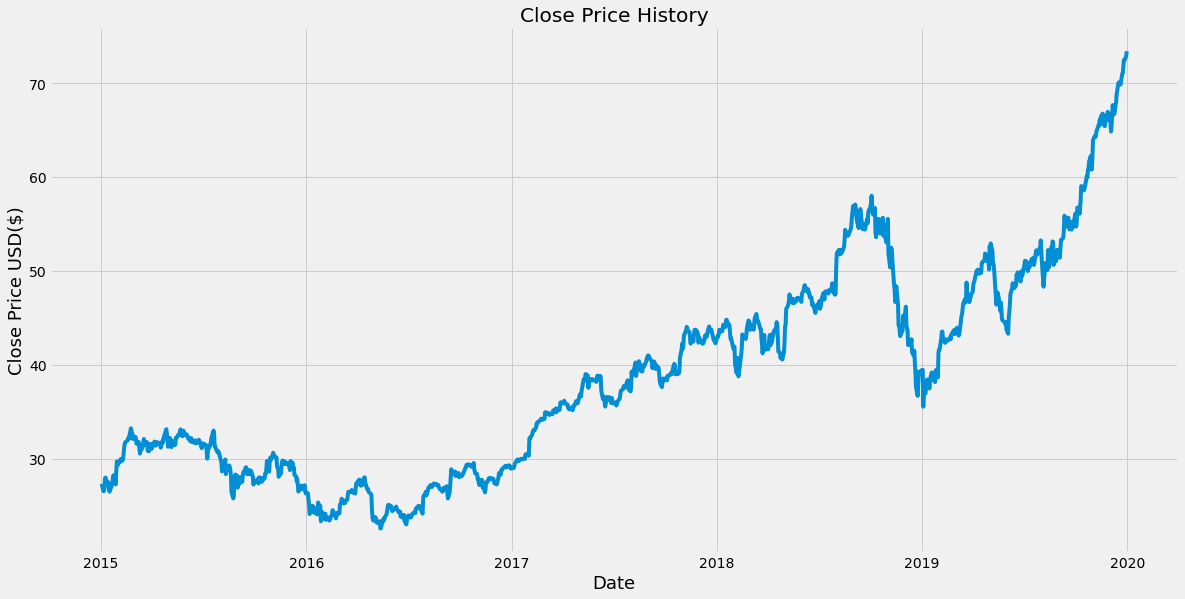

In [37]:
#visualize the closing price history
plt.figure(figsize=(18,9))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [38]:
#prepare data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(df['Close'].values.reshape(-1,1))

prediction_days=60

x_train=[]
y_train=[]

for x in range(prediction_days,len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])





In [39]:
#Convert the x_train and y_train to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [40]:

#Build the LSTM Model

model=Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # For next closing values

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [41]:
#Train the model
model.fit(x_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
38/38 [==============================] - 7s 80ms/step - loss: 0.0486
Epoch 2/20
38/38 [==============================] - 3s 83ms/step - loss: 0.0032
Epoch 3/20
38/38 [==============================] - 3s 83ms/step - loss: 0.0032
Epoch 4/20
38/38 [==============================] - 3s 84ms/step - loss: 0.0024
Epoch 5/20
38/38 [==============================] - 3s 83ms/step - loss: 0.0028
Epoch 6/20
38/38 [==============================] - 3s 83ms/step - loss: 0.0024
Epoch 7/20
38/38 [==============================] - 3s 84ms/step - loss: 0.0026
Epoch 8/20
38/38 [==============================] - 3s 84ms/step - loss: 0.0025
Epoch 9/20
38/38 [==============================] - 3s 84ms/step - loss: 0.0024
Epoch 10/20
38/38 [==============================] - 3s 84ms/step - loss: 0.0019
Epoch 11/20
38/38 [==============================] - 3s 84ms/step - loss: 0.0019
Epoch 12/20
38/38 [==============================] - 3s 84ms/step - loss: 0.0022
Epoch 13/20
38/38 [==================

In [42]:
# TEST THE MODEL ACCURACY ON EXISTING DATA 

#Load Test Data
test_start=dt.datetime(2020,1,1)
test_end=dt.datetime.now()

test_data=web.DataReader(company,'yahoo',test_start,test_end)
actual_prices=test_data['Close'].values

total_dataset=pd.concat((df['Close'], test_data['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs=model_inputs.reshape(-1,1)
model_inputs=scaler.transform(model_inputs)


In [43]:
#Make Predictions on Test DATA

x_test=[]

for x in range(prediction_days,len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x,0])

#Convert the data to a numpy array
x_test=np.array(x_test)
#Reshape the data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [44]:
#Get the models predicted price values 
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

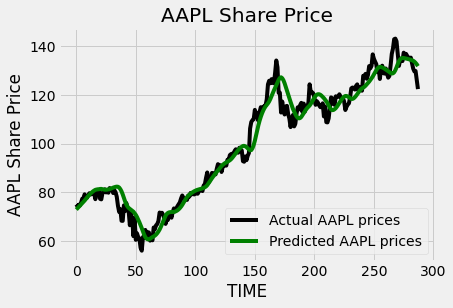

In [45]:
#Plot the data
plt.plot(actual_prices, color ="black",label=f"Actual {company} prices")
plt.plot(predictions, color ="green",label=f"Predicted {company} prices")
plt.title(f"{company} Share Price")
plt.xlabel('TIME')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [46]:
#Predict NEXT DAY

real_data=[model_inputs[len(model_inputs)+1-prediction_days : len(model_inputs+1),0]]
real_data=np.array(real_data)
real_data=np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

prediction_real=model.predict(real_data)
prediction_real=scaler.inverse_transform(prediction_real)

print(f"Predictions : {prediction_real}")


Predictions : [[130.86165]]
